#Settings

Reference : This code builds on lecture notes of Soheil Faizi (that has some errors which are fixed here!)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision.transforms import ToTensor
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import random_split
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
input_size = 784 # 28x28
torch.manual_seed(42)

#Defining The Neural Architecture & A Test-Train-Validation Split of MNIST

In [ ]:
def MNIST_data_generation(validation_size):
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor()
    )


    train_size = len(training_data) - validation_size

    training_data, validation_data = random_split(training_data, [train_size, validation_size])

    train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

    print(f"Training Data Size: {len(training_data)}, Validation Data Size: {len(validation_data)}, Test Data Size: {len(test_data)}")
    return train_loader, validation_loader, test_loader

In [ ]:
class Net(nn.Module):
      def __init__(self, input_size, hidden_size, num_classes):
          super().__init__()
          self.fc1 = nn.Linear(input_size, hidden_size)
          self.fc2 = nn.Linear(hidden_size, num_classes)

      #R^{28 x 28} \ni  x -> A_2 o ReLU (A1(x)) \in R^{num-classes}
      #where A1 : R^{28 x 28} -> R^{hidden_size} and A2 : R^{hidden-size} -> R^{num-classes} are trainable affine transforms

      def forward(self, x):
          x = x.view(x.size(0), -1)
          x = self.fc1(x)
          x = F.relu(x)
          x = self.fc2(x)
          return x

#Hyperparameters

In [ ]:
num_epochs = 20
batch_size = 128
eta = .001
validation_size = 52*(10**3)

In [ ]:
train_loader, validation_loader, test_loader  = MNIST_data_generation(validation_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 302507412.45it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28302732.20it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 199904364.57it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5324351.25it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training Data Size: 8000, Validation Data Size: 52000, Test Data Size: 10000


We can show a grid of what a batch of data will look like using the make_grid function from torchvision.

(everytime you run the following sampler - you should get a different mini-batch of images)

images.shape: torch.Size([128, 1, 28, 28])


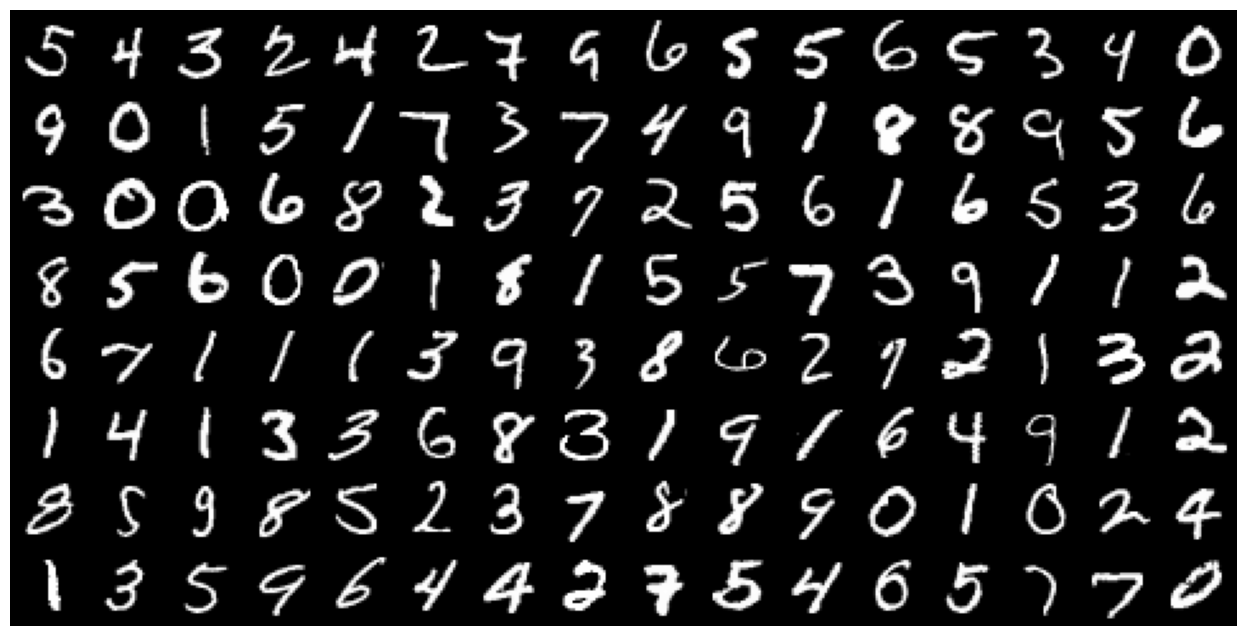

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Defining The Neural Training Functions

First we will create a "get_loss" function to compute the loss.

(This function is flexible in terms of taking as input any loss function as the "criterion" input. )

Then we create a "get_accuracy" function to compute the classification accuracy

get_loss is what we optimize for and classification accuracy is the downstream meaure of performance.


In [ ]:
@torch.no_grad()
def get_loss(loader, criterion, model):
    loss_mini_batch_list = []
    for index, (data, labels) in enumerate(loader):
      # Giving data to cuda
        data = data.reshape(data.size(0), -1).to(device=device)
        #Recall that each MNIST image is originally a 28 x 28 matrix which was in the last 2 dimensions of data
        #The "-1" vectorizes the last 2 dimensions of data
        #So now,  data is now a mini-batch-size x (28^2) matrix - as what the "model" i.e the net requires to get as input
        labels = labels.to(device=device)
        # forward pass
        y_hat = model(data)
        loss = criterion(y_hat, labels)
        loss_mini_batch_list.append(loss)
    return loss_mini_batch_list


def get_accuracy(loader, model):
    correct_pred = 0
    num_samples = 0
    #model.eval()
    for data, labels in loader:
        data = data.reshape(-1, 28*28).to(device=device)
        labels = labels.to(device=device)

        scores = model(data)
        _, preds = scores.max(1)
        correct_pred += (preds == labels).sum().item()
        num_samples += labels.size(0)


    return (float(correct_pred)/float(num_samples))*100

    #print(f'There were {correct_pred} correct predictions out of {num_samples} samples with and accuracy of {float(correct_pred)/float(num_samples)*100:.2f}')
    #model.train()


We can now train our network in the Neural_Training function below.

The function is flexible in terms of taking as input any gradient based optimizer "opt" as input and any loss function as the "criterion" input.

In [ ]:
def Neural_Training (epochs, lr, model, train_loader, criterion, optimizer, test_loader):
    train_loss_dynamics = []
    test_loss_dynamics = []
    train_accuracy_dynamics = []
    test_accuracy_dynamics = []
    #validation_loss_dynamics = []
    accuracy = []

    for epoch in range(epochs):
        training_loss_list = []
        for index, (data, labels) in enumerate(train_loader):
            # Giving data to cuda
            data = data.reshape(data.size(0), -1).to(device=device)
            labels = labels.to(device=device)
            # forward pass
            y_hat = model(data)
            loss = criterion(y_hat, labels)

            #Computing The Gradient On The Mini-Batch Loss
            loss.backward()

            #Computing The ADAM Update Using The Above Computed Stochastic Gradient
            optimizer.step()
            optimizer.zero_grad()


        #validation_loss = torch.stack(get_loss(validation_loader, criterion, model)).mean().item()
        training_loss = torch.stack(get_loss(train_loader, criterion, model)).mean().item()
        test_loss = torch.stack(get_loss(test_loader, criterion, model)).mean().item()
        #The above computes the empirical and test loss on the whole training and the test data respectively.

        train_accuracy_dynamics.append(get_accuracy(train_loader,model))
        test_accuracy_dynamics.append(get_accuracy(test_loader,model))
        #The above computes the empirical and test classification risk on the whole training and the test data respectively.

        train_loss_dynamics.append(training_loss)
        test_loss_dynamics.append(test_loss)
        #validation_loss_dynamics.append(validation_loss)

        print (f'Epoch [{epoch+1}/{epochs}]: The training loss is {training_loss:.4f}')

    return train_accuracy_dynamics, train_loss_dynamics, test_accuracy_dynamics, test_loss_dynamics

# Training An Underparameterized Model

The model can now be initialized and a summary is printed below. We will create a model which has a width of 10. It can be seen that the number of parameters is 7,960 so were in the under-parametrized regime - since the number of parameters are less than the number of samples.

In [ ]:
u_model = Net(input_size=input_size, hidden_size=10, num_classes=10).to(device)
summary(u_model, (1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
            Linear-2                   [-1, 10]             110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
u_train_acc, u_train_loss, u_test_acc, u_test_loss = Neural_Training(num_epochs, eta, u_model, train_loader, nn.CrossEntropyLoss(), torch.optim.Adam(u_model.parameters(), lr=eta),
                           test_loader)

Epoch [1/20]: The training loss is 1.4493
Epoch [2/20]: The training loss is 0.8500
Epoch [3/20]: The training loss is 0.6091
Epoch [4/20]: The training loss is 0.5018
Epoch [5/20]: The training loss is 0.4403
Epoch [6/20]: The training loss is 0.4040
Epoch [7/20]: The training loss is 0.3740
Epoch [8/20]: The training loss is 0.3519
Epoch [9/20]: The training loss is 0.3319
Epoch [10/20]: The training loss is 0.3187
Epoch [11/20]: The training loss is 0.3069
Epoch [12/20]: The training loss is 0.2972
Epoch [13/20]: The training loss is 0.2864
Epoch [14/20]: The training loss is 0.2773
Epoch [15/20]: The training loss is 0.2736
Epoch [16/20]: The training loss is 0.2647
Epoch [17/20]: The training loss is 0.2634
Epoch [18/20]: The training loss is 0.2555
Epoch [19/20]: The training loss is 0.2476
Epoch [20/20]: The training loss is 0.2470


#Training An Overparameterized Model

In [ ]:
o_model = Net(input_size=input_size, hidden_size=1500, num_classes=10).to(device)
summary(o_model, (1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1500]       1,177,500
            Linear-2                   [-1, 10]          15,010
Total params: 1,192,510
Trainable params: 1,192,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 4.55
Estimated Total Size (MB): 4.56
----------------------------------------------------------------


Lets do the training! (using the ADAM optimizer)

In [ ]:
o_train_acc, o_train_loss, o_test_acc, o_test_loss = Neural_Training(num_epochs, eta, o_model, train_loader, nn.CrossEntropyLoss(), torch.optim.Adam(o_model.parameters(), lr=eta),
                           test_loader)

Epoch [1/20]: The training loss is 0.2997
Epoch [2/20]: The training loss is 0.2075
Epoch [3/20]: The training loss is 0.1399
Epoch [4/20]: The training loss is 0.1102
Epoch [5/20]: The training loss is 0.0745
Epoch [6/20]: The training loss is 0.0517
Epoch [7/20]: The training loss is 0.0431
Epoch [8/20]: The training loss is 0.0260
Epoch [9/20]: The training loss is 0.0185
Epoch [10/20]: The training loss is 0.0142
Epoch [11/20]: The training loss is 0.0110
Epoch [12/20]: The training loss is 0.0080
Epoch [13/20]: The training loss is 0.0074
Epoch [14/20]: The training loss is 0.0052
Epoch [15/20]: The training loss is 0.0042
Epoch [16/20]: The training loss is 0.0037
Epoch [17/20]: The training loss is 0.0031
Epoch [18/20]: The training loss is 0.0027
Epoch [19/20]: The training loss is 0.0026
Epoch [20/20]: The training loss is 0.0021


#Comparative Plots : Underparameterized vs Overparameterized

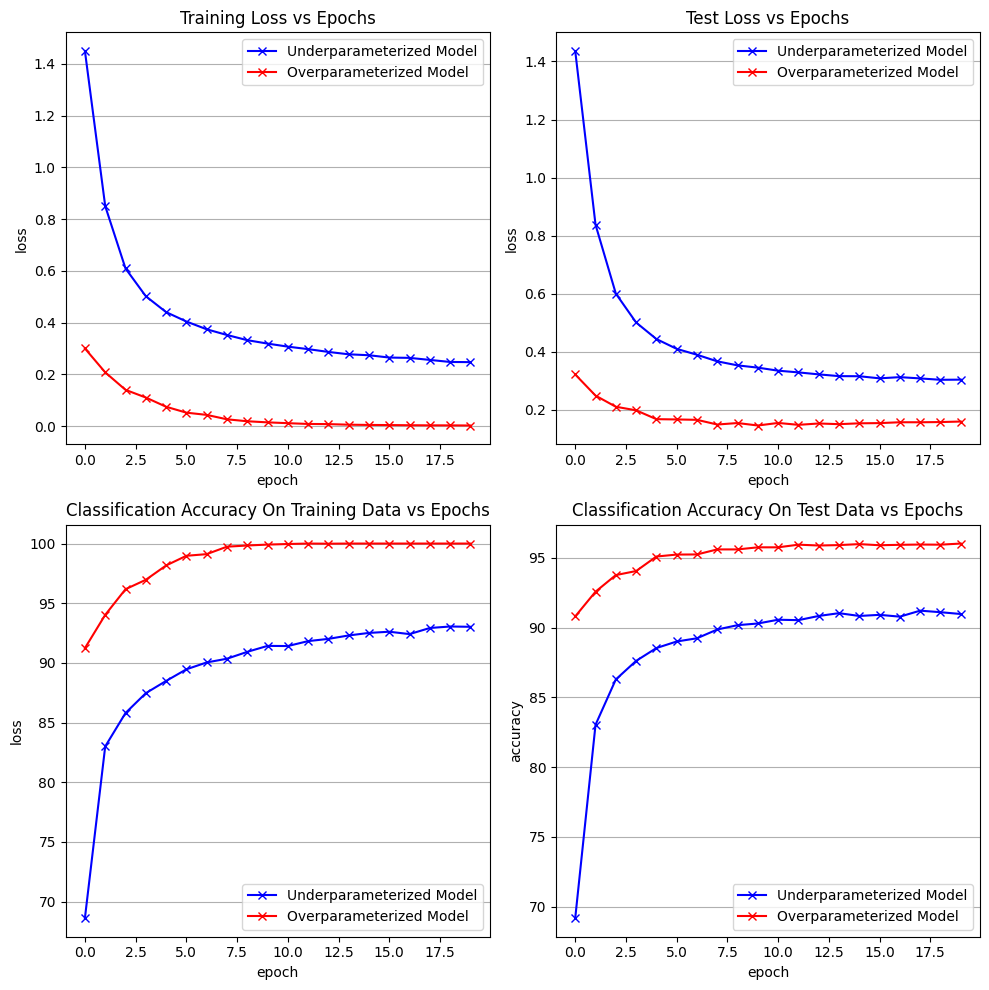

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(u_train_loss, '-bx')
axs[0,0].plot(o_train_loss, '-rx')
axs[0,0].set_xlabel('epoch')
axs[0,0].set_ylabel('loss')
axs[0,0].legend(['Underparameterized Model', 'Overparameterized Model'])
axs[0,0].set_title('Training Loss vs Epochs')
axs[0,0].yaxis.grid(True)

axs[0,1].plot(u_test_loss, '-bx')
axs[0,1].plot(o_test_loss, '-rx')
axs[0,1].set_xlabel('epoch')
axs[0,1].set_ylabel('loss')
axs[0,1].legend(['Underparameterized Model', 'Overparameterized Model'])
axs[0,1].set_title('Test Loss vs Epochs')
axs[0,1].yaxis.grid(True)

axs[1,0].plot(u_train_acc, '-bx')
axs[1,0].plot(o_train_acc, '-rx')
axs[1,0].set_xlabel('epoch')
axs[1,0].set_ylabel('loss')
axs[1,0].legend(['Underparameterized Model', 'Overparameterized Model'])
axs[1,0].set_title('Classification Accuracy On Training Data vs Epochs')
axs[1,0].yaxis.grid(True)

axs[1,1].plot(u_test_acc, '-bx')
axs[1,1].plot(o_test_acc, '-rx')
axs[1,1].set_xlabel('epoch')
axs[1,1].set_ylabel('accuracy')
axs[1,1].legend(['Underparameterized Model', 'Overparameterized Model'])
axs[1,1].set_title('Classification Accuracy On Test Data vs Epochs')
axs[1,1].yaxis.grid(True)

plt.tight_layout()